In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
image_dim = 28*28
latent_dim = 2
learning_rate = 0.005
batch_size = 512

In [4]:
class Encoder(nn.Module):
  def __init__(self, image_dim, hidden_dims, latent_dim):
    super(Encoder, self).__init__()
    dims = [image_dim] + hidden_dims
    self.encoder = nn.Sequential()
    for in_dim, out_dim in zip(dims, dims[1:]):
      self.encoder.append(nn.Linear(in_dim, out_dim, bias=False))
      self.encoder.append(nn.BatchNorm1d(out_dim))
      self.encoder.append(nn.LeakyReLU(0.2))

    self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
    self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

  def forward(self, x):
    x = x.view(-1, image_dim)
    z = self.encoder(x)
    mu, logvar = self.fc_mu(z), self.fc_logvar(z)
    return mu, logvar

In [5]:
class Decoder(nn.Module):
  def __init__(self, image_dim, hidden_dims, latent_dim):
    super(Decoder, self).__init__()
    dims = [latent_dim] + hidden_dims[::-1]
    self.decoder = nn.Sequential()
    for in_dim, out_dim in zip(dims, dims[1:]):
        self.decoder.append(nn.Linear(in_dim, out_dim, bias=False))
        self.decoder.append(nn.BatchNorm1d(out_dim))
        self.decoder.append(nn.LeakyReLU(0.2))
    self.decoder.append(nn.Linear(dims[-1], image_dim))
    self.decoder.append(nn.Sigmoid())

  def forward(self, z):
    z = self.decoder(z)
    z = z.view(-1, 1, 28, 28)
    return z

In [6]:
class VAE(nn.Module):
  def __init__(self, image_dim, latent_dim, hidden_dims=[512, 256]):
    super(VAE, self).__init__()
    self.encoder = Encoder(image_dim, hidden_dims, latent_dim)
    self.decoder = Decoder(image_dim, hidden_dims, latent_dim)

  def reparametrize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu

  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparametrize(mu, logvar)
    return self.decoder(z), mu, logvar

  def loss_fn(self, x, x_hat, mu, logvar):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + 0.00025*kl_divergence

In [7]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
vae = VAE(image_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [9]:
vae.train()
for e in range(20):
  with tqdm(train_dataloader) as pbar:
    for i, (x, _) in enumerate(pbar):
      x = x.to(device)
      x_hat, mu, logvar = vae(x)
      loss = vae.loss_fn(x, x_hat, mu, logvar)

      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

      if i % 10 == 0:
        pbar.set_description(f"Epoch {e+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 80189.5625: 100%|██████████| 118/118 [00:12<00:00,  9.82it/s]
Epoch 2 | Loss: 77305.7969: 100%|██████████| 118/118 [00:14<00:00,  8.42it/s]
Epoch 3 | Loss: 79001.3828: 100%|██████████| 118/118 [00:08<00:00, 13.14it/s]
Epoch 4 | Loss: 76926.3047: 100%|██████████| 118/118 [00:09<00:00, 13.03it/s]
Epoch 5 | Loss: 75339.9766: 100%|██████████| 118/118 [00:08<00:00, 13.12it/s]
Epoch 6 | Loss: 75207.9922: 100%|██████████| 118/118 [00:08<00:00, 14.11it/s]
Epoch 7 | Loss: 75834.3906: 100%|██████████| 118/118 [00:08<00:00, 13.14it/s]
Epoch 8 | Loss: 72945.9375: 100%|██████████| 118/118 [00:08<00:00, 13.13it/s]
Epoch 9 | Loss: 73875.1094: 100%|██████████| 118/118 [00:08<00:00, 13.84it/s]
Epoch 10 | Loss: 73418.2031: 100%|██████████| 118/118 [00:09<00:00, 12.08it/s]
Epoch 11 | Loss: 73222.8359: 100%|██████████| 118/118 [00:08<00:00, 13.28it/s]
Epoch 12 | Loss: 74349.1875: 100%|██████████| 118/118 [00:08<00:00, 13.19it/s]
Epoch 13 | Loss: 72446.7578: 100%|██████████| 118/118 [00:08<

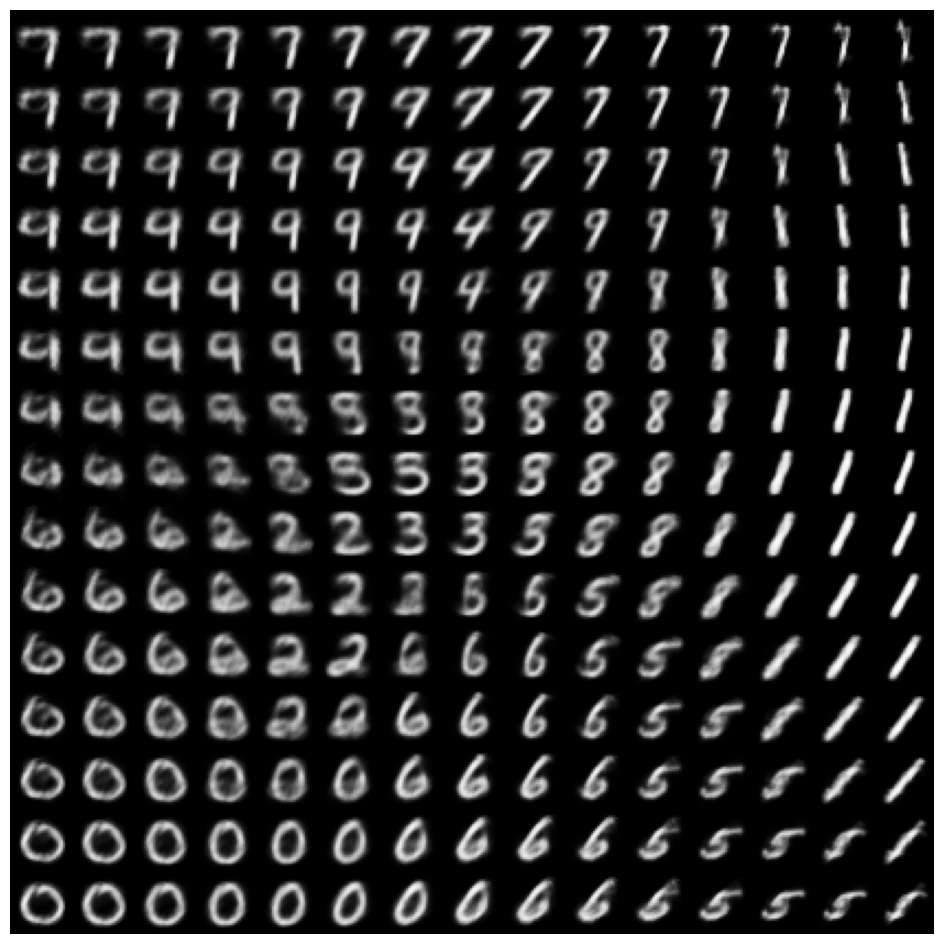

In [11]:
vae.eval()
imgs = None
with torch.no_grad():
  for x in torch.linspace(-10, 10, 15):
    row = None
    for y in torch.linspace(-10, 10, 15):
      z = torch.tensor([x, y], dtype=torch.float32).to(device)
      img = vae.decoder(z.unsqueeze(0)).view(28, 28)
      row = img if row is None else torch.cat((row, img), 1)
    imgs = row if imgs is None else torch.vstack((row, imgs))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(imgs.cpu().detach().numpy(), cmap="gray")

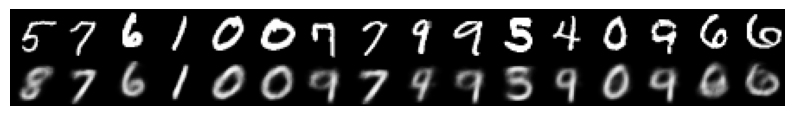

In [12]:
x, _ = next(iter(test_dataloader))
x = x.view(-1, 28, 28).to(device)
with torch.no_grad():
  x_hat, _, _ = vae(x)
  x_hat = x_hat.view(-1, 28, 28)

imgs = None
for i in range(16):
  cat = torch.vstack((x[i], x_hat[i]))
  imgs = cat if imgs is None else torch.hstack((imgs, cat))
plt.figure(figsize=(10, batch_size // 4))
plt.axis("off")
plt.imshow(imgs.cpu().detach(), cmap="gray")